##  流程

#### (1) 用OHLCV計算每一檔商品的權重
#### (2) 對權重做標準化 => mean=0, std=1 
#### (3) 每天都以initial_cash去分配資金
#### (4) 計算每一檔商品的部位
#### (5) 以開盤價當作交易價格 
#### (6) 每天開盤時計算損益

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

In [2]:
class alpha_platform(object):
    def __init__(self, data_path, max_look_back, initial_cash):
        self.data_path = data_path
        self.initial_cash = initial_cash
        self.max_look_back = max_look_back
        self.all_table = self._load_table()
        self.data_len = len(self.all_table)
        self.num_commodity = len(self.all_table.columns.levels[0])
        self.reset()
        
    def _load_table(self):
        file_name = os.listdir(self.data_path)
        table_list = []
        for i in range(len(file_name)):
            temp = pd.read_csv(self.data_path+'/'+file_name[i])
            temp['Date'] = pd.to_datetime(temp['Date'])
            temp = temp.set_index('Date')
            table_list.append(temp)
        columns_name = [file_name[i][:4] for i in range(len(file_name))]
        return pd.concat(table_list, axis=1, join='inner', keys=columns_name)
    
    def reset(self):
        self.step_counter = self.max_look_back
        self.total_value = self.initial_cash   
        self.position_vector = np.zeros([self.num_commodity])
        self.profit_list = []
        self.total_value_list = []
        
    def get_state(self):
        return self.all_table.iloc[self.step_counter-self.max_look_back:self.step_counter]
        
    def get_trade_data(self):
        return self.all_table.iloc[self.step_counter-1:self.step_counter+1].loc[:, (slice(None), 'Open')].values
        
    def create_alpha(self, neutralization=True):  
        cal_data = self.get_state() 
        
        ## ex.以「-returns*vol」為例:
        ######################################## create_alpha ########################################
        
        ############# 拿到需要的資料 #############
        close = cal_data.loc[:, (slice(None), 'Close')].values
        vol = cal_data.loc[:, (slice(None), 'Vol')].values
        #########################################
        
        ############# 撰寫expression #############
        tem_weights = - (close[-1,:] - close[-2,:]) * vol[-1,:] ## -returns * vol
        ##########################################
        
        ###############################################################################################
        
        assert len(tem_weights) == self.num_commodity ## 確認權重長度正確
        
        if neutralization: ## 標準化 & 中性化 
            self.weights = (tem_weights - np.mean(tem_weights)) / np.std(tem_weights)
        else:
            self.weights = tem_weights / np.std(tem_weights)
        
    def simulate(self):
        with progressbar.ProgressBar(min_value=self.step_counter, max_value=len(self.all_table)) as bar:
            while self.step_counter < len(self.all_table):
                trade_data = self.get_trade_data()
                day_profit = sum(self.position_vector * trade_data[-1,:] - self.position_vector * trade_data[-2,:]) ## 今日的投組價值-昨日投組價值
                self.profit_list.append(day_profit)
                self.total_value += day_profit
                self.total_value_list.append(self.total_value)
                
                self.create_alpha(neutralization=True)
                self.position_vector = (self.initial_cash * self.weights) / trade_data[-1,:] ## 計算當日的部位分布 用來給明日計算

                self.step_counter += 1
                bar.update(self.step_counter)
                
        print('Compelete the simulation!')
        
    def cal_info(self):
        self.xs = np.asarray([self.all_table.index.values[i] for i in range(self.max_look_back, self.data_len)])
        
        self.drawdown_lis = []
        for i in range(len(self.total_value_list)):
            max_temp_equity = max(self.total_value_list[:i+1])
            drawdown = self.total_value_list[i] - max_temp_equity
            self.drawdown_lis.append(drawdown)     
            
    def plot_info(self):
        self.cal_info()
        
        font = {'weight': 'normal', 'size': 20}
        
        plt.close() 
        plt.figure(figsize = (20,10))

        plt.subplot(211)  
        plt.title('Equity', font)
        plt.plot(self.xs, self.total_value_list)
        plt.xlabel('Date', font)
        plt.ylabel('Value', font)
        plt.grid(linestyle = '-.', c='C7')
        
        plt.subplots_adjust(wspace = 0, hspace = 0.3)

        plt.subplot(212)  
        plt.title('Drawdown', font)
        plt.plot(self.xs, self.drawdown_lis, c = 'r')
        plt.xlabel('Date', font)
        plt.ylabel('Drawdown', font)
        plt.grid(linestyle = '-.', c='C7')
        
        plt.show()
        plt.close()        

100% (3481 of 3481) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


Compelete the simulation!


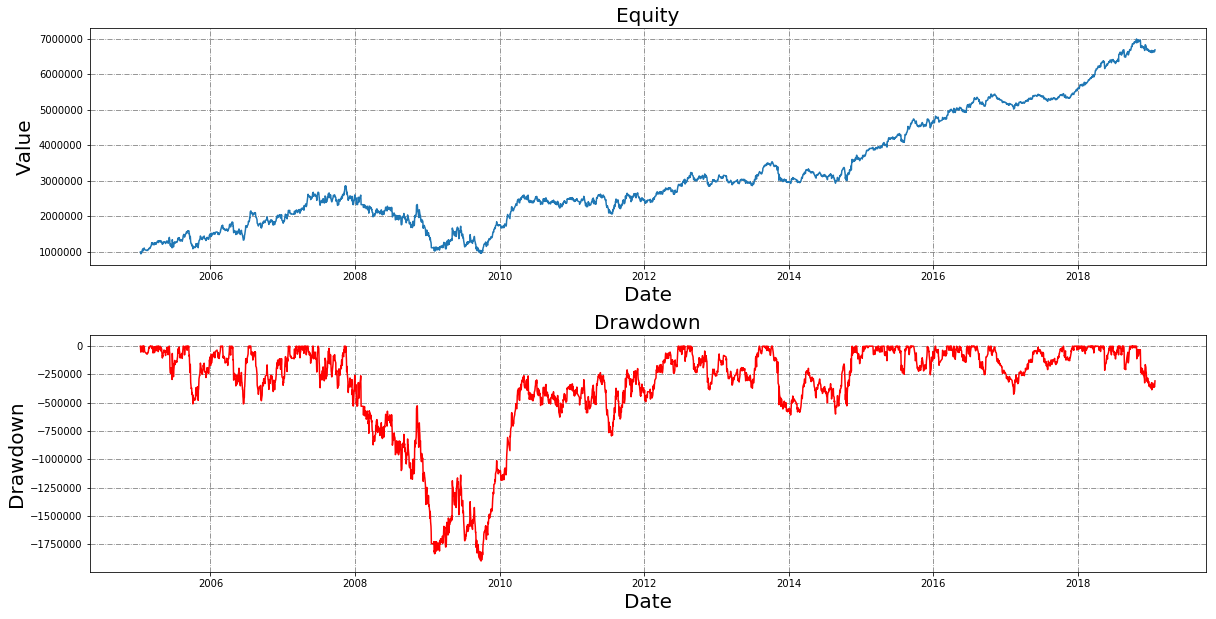

In [3]:
data_path = 'D:/Documents/ipython/Backtest_sys/Alpha_model/data'

alpha = alpha_platform(data_path, max_look_back=7, initial_cash=1000000)

alpha.simulate()
alpha.plot_info()

In [4]:
alpha.profit_list

[0.0,
 -29674.780811563483,
 -22848.351674927522,
 12242.911000402208,
 33962.997917966451,
 1244.0557706256222,
 14053.46520547726,
 44259.212166059937,
 26655.61005554095,
 3583.0122032329673,
 -52406.455030714162,
 61070.659092217509,
 -7468.4146026575763,
 25442.166045191814,
 -22212.345370427473,
 -19348.716241985559,
 -8195.490898601769,
 -20952.688444874133,
 372.31302863475867,
 12588.285754634708,
 -3264.4233655906282,
 -1892.1932671309332,
 17843.141373486375,
 14105.268729481148,
 17294.832562496769,
 4889.3321059101727,
 -9048.1270013496687,
 15013.675389196098,
 15297.592594151603,
 -3493.818433621258,
 21496.809180149634,
 30882.597242694406,
 21590.912634276414,
 21011.781675111655,
 46103.873988346895,
 -21330.729129426007,
 20996.297876187833,
 -10903.450168624138,
 -39992.309544140066,
 -8746.404829723615,
 9760.3305350794399,
 5192.0986870802008,
 28146.042606255796,
 11474.992802822555,
 -51136.186605627459,
 38748.217621151649,
 -3119.1182525422919,
 18080.95120609